## COVID 19 FORECASTING IN INDIA, ITALY, USA & BELGIUM

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.api import Holt
import datetime
import pickle

In [4]:
def make_train_test(data,string,ratio):
    
    x = list(data.index)
    y = list(data[string])
    n = len(data)
    if ratio<1:
        x_train = x[:int(ratio*n)]
        y_train = y[:int(ratio*n)]
        x_test = x[int(ratio*n):]
        y_test = y[int(ratio*n):]
        return x_train,y_train,x_test,y_test
    else:
        return x,y


In [5]:
def dump_pickle(obj,name):
    file = open(name+str('.pkl'), 'wb')
    pickle.dump(obj, file)
def load_pickle(pkl_name):
    readfile = open(pkl_name, 'rb')
    model = pickle.load(readfile)
    return model


In [6]:
def predict(start_date,end_date,country,model_cnf,model_rec,model_dea,data,output_path,forecast):
    sd = [int(i) for i in start_date.split("-")]
    s_date = datetime.date(sd[0],sd[1],sd[2])
    ed = [int(i) for i in end_date.split("-")]
    e_date = datetime.date(ed[0],ed[1],ed[2])
    
    
    train_ed = data.tail(1)['Date'].item()
    train_idx = data.tail(1).index.item()
    train_ed = [int(i) for i in train_ed.split("-")]
    train_edate = datetime.date(train_ed[0],train_ed[1],train_ed[2])
    e_init_diff = (e_date - train_edate).days
    diff = (e_date - s_date).days
    date_seq = [(s_date + datetime.timedelta(days=i)).strftime("%Y-%m-%d") for i in range(diff+1)]
    from_train_idx_date_seq = [(train_edate + datetime.timedelta(days=i)).strftime("%Y-%m-%d") for i in range(1,e_init_diff+1)]
    #print(date_seq)
    #print(from_train_idx_date_seq)
    flag="0"
    data_dates = data['Date'].to_list()
    last_date = start_date
    pred_cnf = []
    pred_rec = []
    pred_dea = []


    while flag=="0":
        for i in date_seq:
            if i in data_dates:
                pred_cnf.append(data.loc[data['Date']==i]['Confirmed'].item())
                pred_rec.append(data.loc[data['Date']==i]['Recovered'].item())
                pred_dea.append(data.loc[data['Date']==i]['Deaths'].item())
                flag+="1"
            else:
                last_date = i
                flag+="2"
                break


    #print(flag)
    #print(pred_cnf)

    if "2" not in flag:
        pass
    else:
        #print(last_date)
        t = list(np.arange( train_idx+1 , train_idx+e_init_diff+1 ,1))
        #print(t)
        cnf_forecast = list(model_cnf.forecast(len(t))[0].astype(int))
        rec_forecast = list(model_rec.forecast(len(t))[0].astype(int))
        dea_forecast = list(model_dea.forecast(len(t))[0].astype(int))
        
        if forecast:
            cnf_forecast_range = list(model_cnf.forecast(len(t))[2].astype(int))
            rec_forecast_range = list(model_rec.forecast(len(t))[2].astype(int))
            dea_forecast_range = list(model_dea.forecast(len(t))[2].astype(int))

        
        #print(cnf_forecast)
        forecast_start_index = from_train_idx_date_seq.index(last_date)
        #print(forecast_start_index)
        #print(cnf_forecast[forecast_start_index:])
        pred_cnf.extend(cnf_forecast[forecast_start_index: ])
        pred_rec.extend(rec_forecast[forecast_start_index:])
        pred_dea.extend(dea_forecast[forecast_start_index:])
    if forecast:
        df_dict = {'Date':date_seq,'Confirmed':pred_cnf,"Confirmed (95%) confidence interval":cnf_forecast_range,"Recovered":pred_rec,"Recovered CI":rec_forecast_range,"Deaths":pred_dea,"Deaths CI":dea_forecast_range}
    else:
        df_dict = {'Date':date_seq,'Confirmed':pred_cnf,"Recovered":pred_rec,"Deaths":pred_dea}
        
    df = pd.DataFrame(df_dict)
    
    df.to_csv(str(output_path)+str(country)+".preds",sep='\t',index=False,header=None)
    return df

In [7]:
def mean_percentage_error(true,pred):
    s = 0
    for i in range(len(true)):
        s+= (abs(true[i]-pred[i])/true[i])*100
    return s/len(true)

In [8]:
def do_shit_arima(country,string,data,a,b,c):
    #x,y = make_train_test(data,string,1)
    model = ARIMA(data[string], order=(a,b,c))
    model_fit = model.fit(disp=0)
    dump_pickle(model_fit,"model_arima_"+str(country)+"_"+str(string))

In [9]:
def give_full_arima(string,data,a,b,c):
    ratio=0.96
    x_train,y_train,x_test,y_test = make_train_test(data,string,ratio)
    x = x_train+x_test
    y = y_train+y_test
    
    model = ARIMA(y_train, order=(a,b,c))
    model_fit = model.fit(disp=0)
    return model_fit

In [10]:
def tune_arima(string,data):
    _,y_train,_,y_test = make_train_test(data,string,0.96)
    min_rmse = 999900
    for a in range(5,1,-1):
        for b in range(1,5):
            for c in range(5):
                try:
                    model = ARIMA(y_train, order=(a,b,c))
                    model_fit = model.fit(disp=0)
                    preds = list(model_fit.forecast(len(y_test))[0])
                    true = list(y_test)
                    #print(preds)
                    #print(true)
                    rmse = np.sqrt(mean_squared_error(preds,true))
                    if rmse<min_rmse:
                        min_rmse = rmse
                        min_a = a
                        min_b = b
                        min_c = c
                except:
                    pass
                    #print("error for ",a,b,c)
    return min_rmse,min_a,min_b,min_c
                

In [11]:
def plot_arima(model,data,string,ratio,fore):
    if fore==False:
        x_train,y_train,x_test,y_test = make_train_test(data,string,ratio)
        x = x_train+x_test
        y = y_train+y_test
        y_pred_holt = list(model.forecast(len(y_test))[0])
    else:
        x,y = make_train_test(data,string,1)
        x_fore = list(np.arange(x[-1]+1,x[-1]+8))
        #print(x_fore)
        y_fore = list(model.forecast(len(x_fore))[0])
        y_fore_ci = list(model.forecast(len(x_fore))[2])
        y_fore_lci = [i[0] for i in y_fore_ci]
        y_fore_uci = [i[1] for i in y_fore_ci]
    #print(y_pred_holt)
    #print(model.forecast(len(y_test)+7))
    
    plt.figure(figsize=(10,10))
    plt.title(str(string)+" cases")
    plt.plot(x,y,color='blue',label='Observed Cases')
    if fore:
        plt.plot(x_fore,y_fore,color='green',label='Forecast for next 7 days')
        plt.plot(x_fore,y_fore_lci,color='orange',label='2 S.Dev. Upper confidence interval limit - Forecast for next 7 days')
        plt.plot(x_fore,y_fore_uci,color='pink',label='2 S.Dev. Lower confidence interval limit - Forecast for next 7 days')
    elif fore==False:
        plt.scatter(x_test,y_pred_holt,color='red',label='Predicted Cases for observed values')
    plt.legend(loc="upper left")
    plt.grid(b=True, which='major', color='#666666', linestyle='-')

# Show the minor grid lines with very faint and almost transparent grey lines
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    if fore==False:
        print("RMSE = ",np.sqrt(mean_squared_error(y_test,y_pred_holt)))
        print("Average Percentage error (in %) = ",mean_percentage_error(y_test,y_pred_holt))

In [12]:
data_india = pd.read_csv("./data/India.csv",sep='\t')

In [13]:
data_italy = pd.read_csv("./data/Italy.csv",sep='\t')

In [14]:
data_us = pd.read_csv("./data/US.csv",sep='\t')

In [15]:
data_bel = pd.read_csv("./data/Belgium.csv",sep='\t')

### Training data till 29th April

In [16]:
data_india.tail(1)

,Date,Confirmed,Recovered,Deaths
90,2020-04-29,33062,8437,1079


In [17]:
data_bel.tail(1)

,Date,Confirmed,Recovered,Deaths
85,2020-04-29,47859,11283,7501


In [18]:
data_us.tail(1)

,Date,Confirmed,Recovered,Deaths
98,2020-04-29,1039909,120720,60967


In [19]:
data_italy.tail(1)

,Date,Confirmed,Recovered,Deaths
89,2020-04-29,203591,71252,27682


## ARIMA Forecasting

In [20]:
from statsmodels.tsa.arima_model import ARIMA

#### Tune ARIMA gives best p,d,q for ARIMA models

In [21]:
# tune_arima('Confirmed',data_india)

# tune_arima('Recovered',data_india)

# tune_arima('Deaths',data_india)

# tune_arima('Confirmed',data_us)

# tune_arima('Recovered',data_us)

# tune_arima('Deaths',data_us)

# tune_arima('Confirmed',data_italy)

# tune_arima('Recovered',data_italy)

# tune_arima('Deaths',data_italy)

# tune_arima('Confirmed',data_bel)

# tune_arima('Recovered',data_bel)

# tune_arima('Deaths',data_bel)

### India

RMSE =  79.99090193945202
Average Percentage error (in %) =  0.2340530532906121


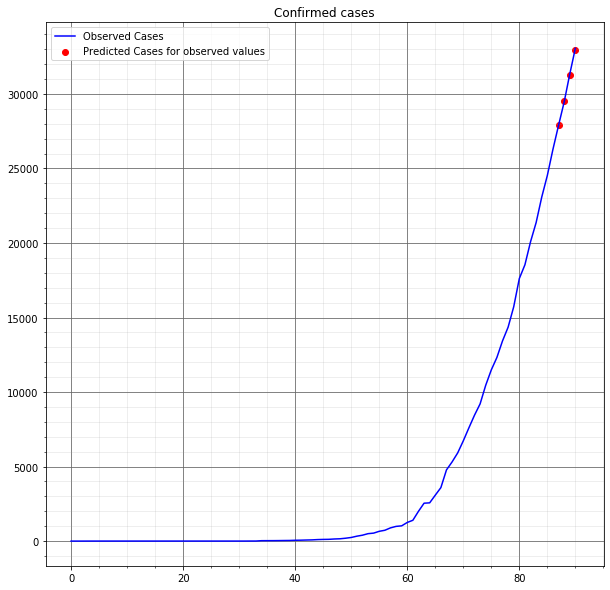

In [16]:
model_cnf = give_full_arima('Confirmed',data_india,5,2,0)
plot_arima(model_cnf,data_india,'Confirmed',0.96,False)

/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


RMSE =  247.73012627671832
Average Percentage error (in %) =  2.7076164029025804


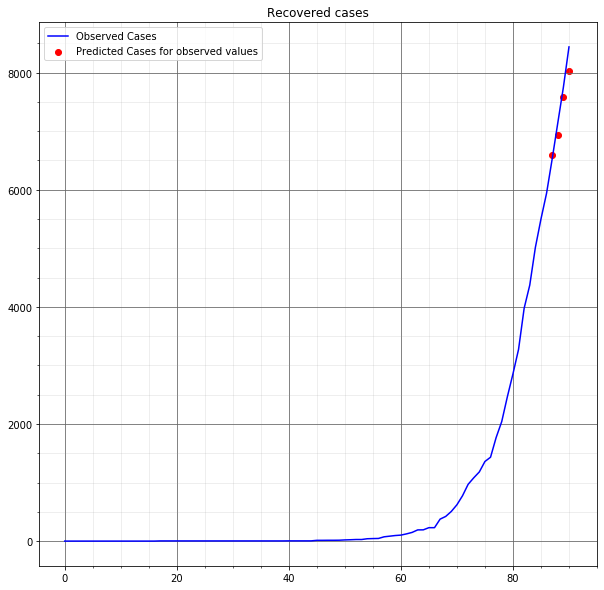

In [17]:
model_rec = give_full_arima('Recovered',data_india,5,2,0)
plot_arima(model_rec,data_india,'Recovered',0.96,False)

RMSE =  23.358309733385468
Average Percentage error (in %) =  1.730870995044023


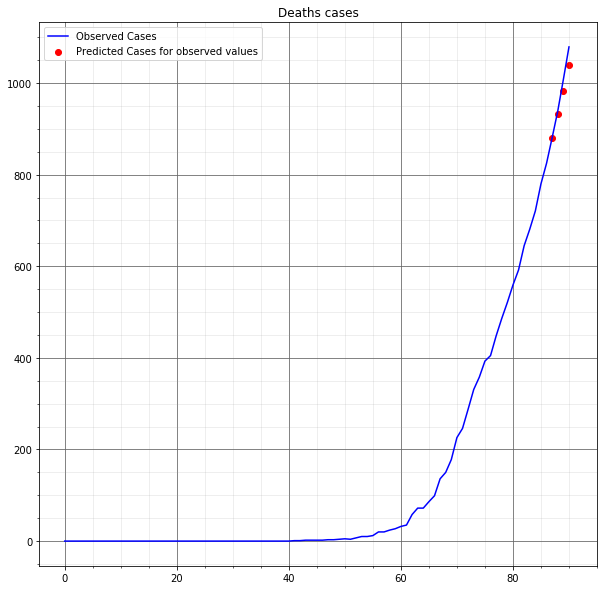

In [18]:
model_dea_ind_train = give_full_arima('Deaths',data_india,2,2,1)
plot_arima(model_dea_ind_train,data_india,'Deaths',0.96,False)

In [19]:
#save models

In [22]:
do_shit_arima('india','Confirmed',data_india,5,2,0)
do_shit_arima('india','Recovered',data_india,5,2,0)
do_shit_arima('india','Deaths',data_india,2,2,1)

In [23]:
model_india_cnf_arima = load_pickle('model_arima_india_Confirmed.pkl')
model_india_rec_arima = load_pickle('model_arima_india_Recovered.pkl')
model_india_dea_arima = load_pickle('model_arima_india_Deaths.pkl')

### forecasting : India

In [25]:
predict("2020-04-30","2020-05-07","India",model_india_cnf_arima,model_india_rec_arima,model_india_dea_arima,data_india,'./test_op/',True)

,Date,Confirmed,Confirmed (95%) confidence interval,Recovered,Recovered CI,Deaths,Deaths CI
0,2020-04-30,34876,"[34561, 35192]",9080,"[8983, 9178]",1144,"[1132, 1157]"
1,2020-05-01,36620,"[36140, 37101]",9776,"[9613, 9939]",1218,"[1196, 1239]"
2,2020-05-02,38439,"[37773, 39104]",10467,"[10197, 10736]",1287,"[1255, 1319]"
3,2020-05-03,40321,"[39465, 41176]",11158,"[10764, 11551]",1359,"[1312, 1406]"
4,2020-05-04,42163,"[41081, 43245]",11879,"[11354, 12403]",1433,"[1372, 1493]"
5,2020-05-05,44051,"[42692, 45410]",12583,"[11901, 13265]",1504,"[1428, 1581]"
6,2020-05-06,45933,"[44309, 47557]",13314,"[12470, 14158]",1580,"[1486, 1673]"
7,2020-05-07,47867,"[45956, 49778]",14044,"[13020, 15067]",1654,"[1543, 1765]"


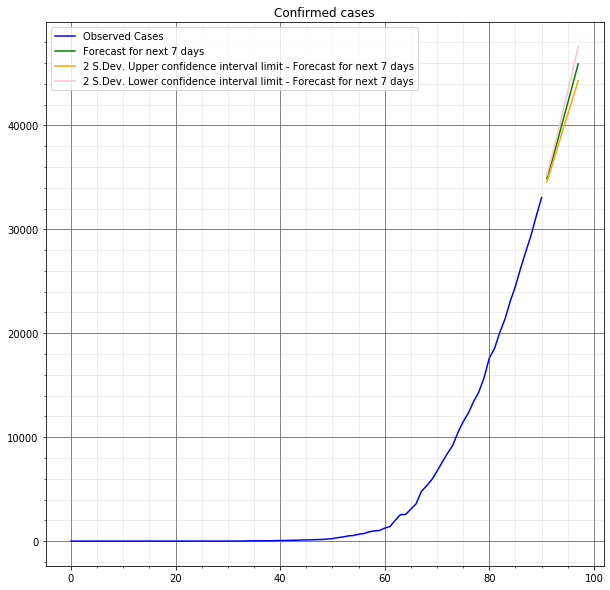

In [77]:
plot_arima(model_india_cnf_arima,data_india,'Confirmed',1,True)

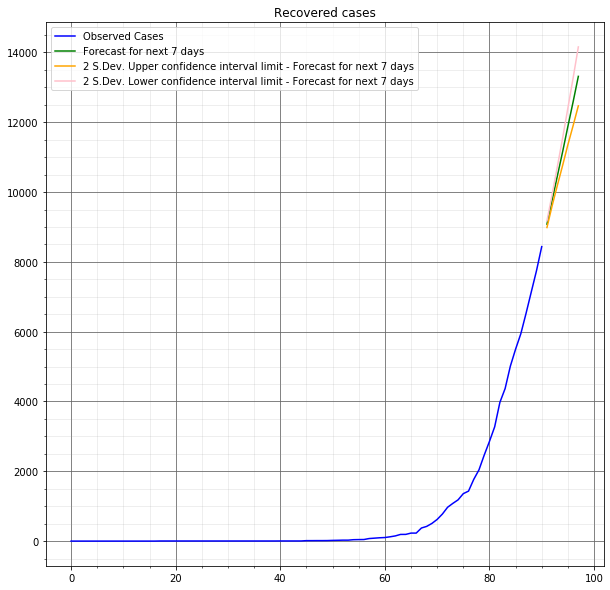

In [78]:
plot_arima(model_india_rec_arima,data_india,'Recovered',1,True)

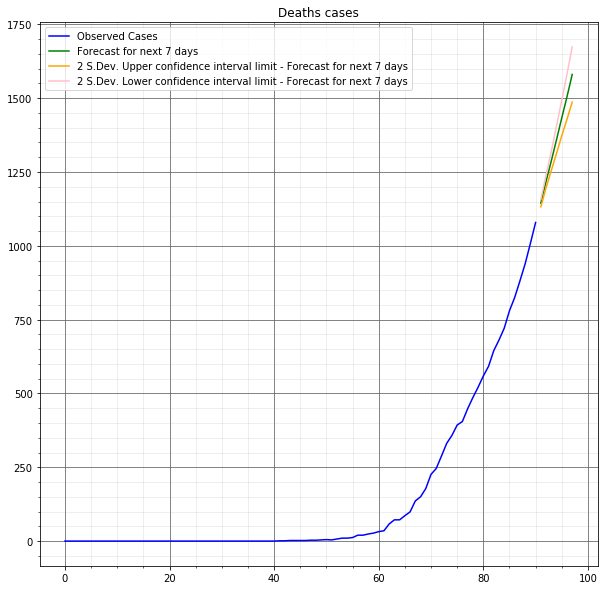

In [79]:
plot_arima(model_india_dea_arima,data_india,'Deaths',1,True)

### US

RMSE =  20879.81898564481
Average Percentage error (in %) =  1.869782774067258


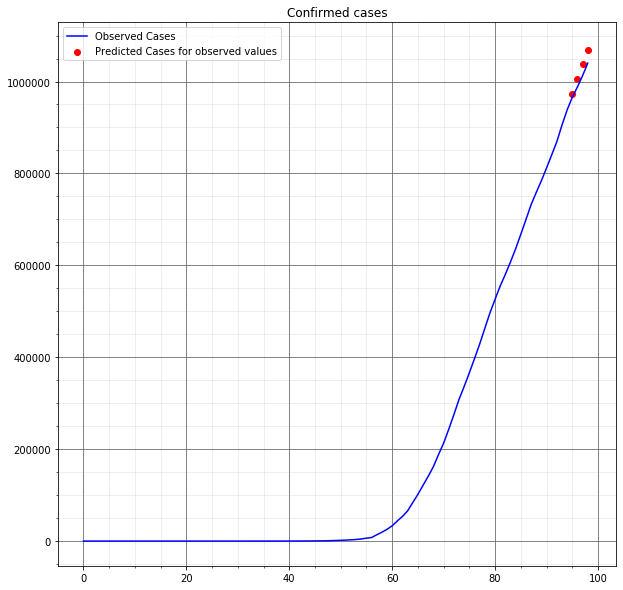

In [80]:
model_cnf = give_full_arima('Confirmed',data_us,2,1,3)
plot_arima(model_cnf,data_us,'Confirmed',0.96,False)

RMSE =  3730.421101213065
Average Percentage error (in %) =  3.2064213954261933


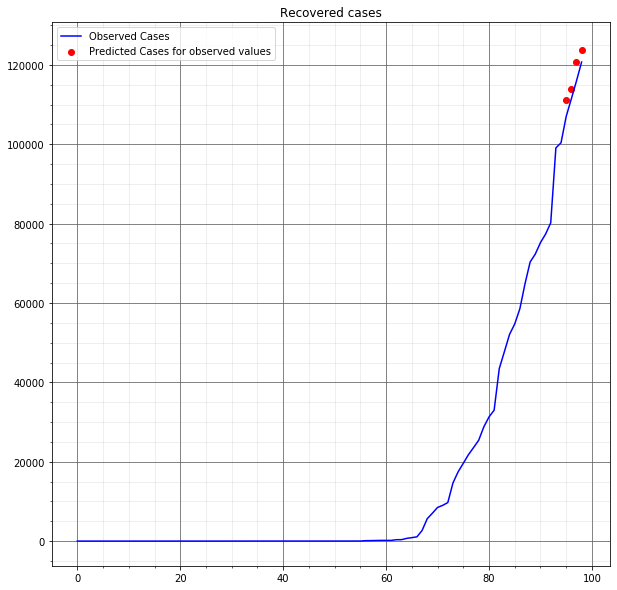

In [81]:
model_rec = give_full_arima('Recovered',data_us,2,1,0)
plot_arima(model_rec,data_us,'Recovered',0.96,False)

RMSE =  1519.0533933656282
Average Percentage error (in %) =  2.571953482263066


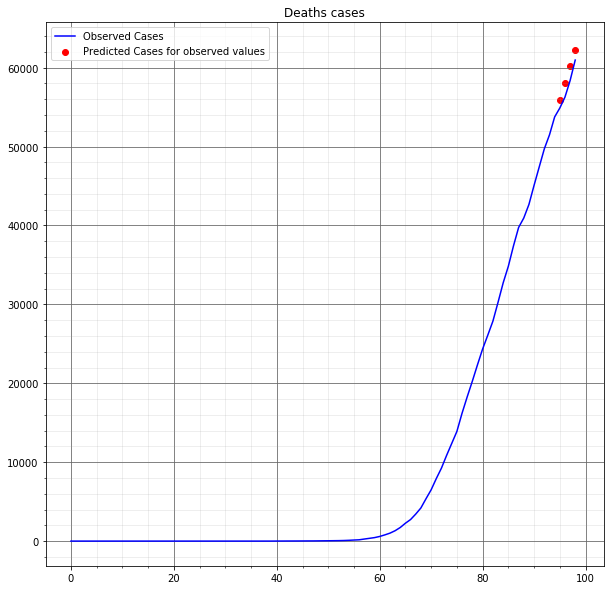

In [82]:
model_dea = give_full_arima('Deaths',data_us,2,1,0)
plot_arima(model_dea,data_us,'Deaths',0.96,False)

### Forcasting USA

In [83]:
do_shit_arima('us','Confirmed',data_us,2,1,3)
do_shit_arima('us','Recovered',data_us,2,1,1)
do_shit_arima('us','Deaths',data_us,2,1,0)

In [84]:
model_us_cnf_arima = load_pickle('model_arima_us_Confirmed.pkl')
model_us_rec_arima = load_pickle('model_arima_us_Recovered.pkl')
model_us_dea_arima = load_pickle('model_arima_us_Deaths.pkl')

In [85]:
predict("2020-04-30","2020-05-07","us",model_us_cnf_arima,model_us_rec_arima,model_us_dea_arima,data_us,'./test_op/',True)

,Date,Confirmed,Confirmed (95%) confidence interval,Recovered,Recovered CI,Deaths,Deaths CI
0,2020-04-30,1067717,"[1063823, 1071611]",125779,"[121938, 129621]",63459,"[62949, 63969]"
1,2020-05-01,1094958,"[1085954, 1103962]",130746,"[125331, 136161]",65928,"[64864, 66991]"
2,2020-05-02,1121803,"[1106589, 1137017]",135696,"[128607, 142784]",68359,"[66635, 70084]"
3,2020-05-03,1148569,"[1126613, 1170525]",140613,"[131843, 149384]",70756,"[68285, 73228]"
4,2020-05-04,1175132,"[1145719, 1204546]",145502,"[134997, 156006]",73120,"[69828, 76412]"
5,2020-05-05,1201545,"[1164088, 1239002]",150361,"[138068, 162654]",75451,"[71275, 79626]"
6,2020-05-06,1227789,"[1181728, 1273850]",155192,"[141054, 169331]",77749,"[72634, 82864]"
7,2020-05-07,1253873,"[1198700, 1309046]",159995,"[143955, 176035]",80016,"[73912, 86120]"


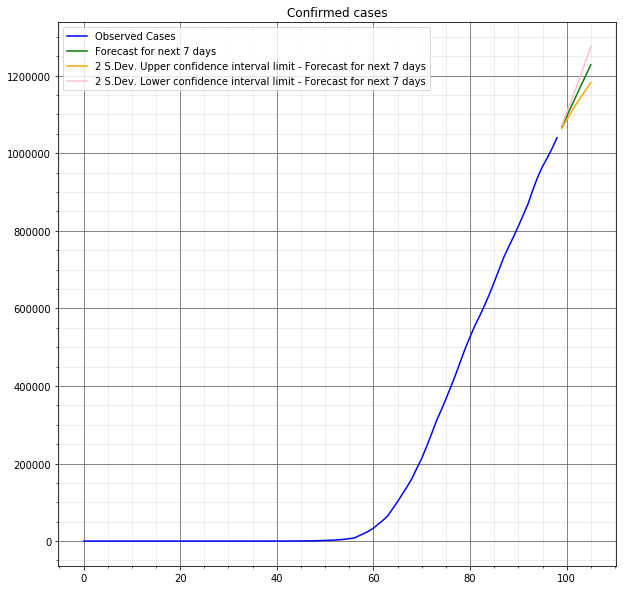

In [86]:
plot_arima(model_us_cnf_arima,data_us,'Confirmed',1,True)

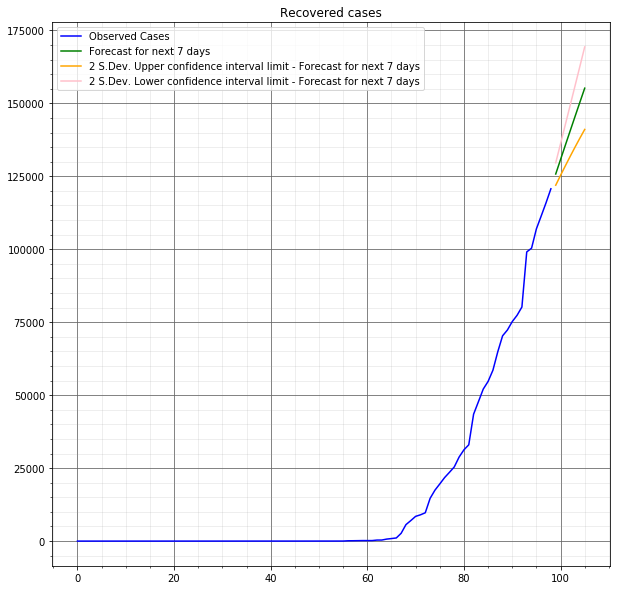

In [87]:
plot_arima(model_us_rec_arima,data_us,'Recovered',1,True)

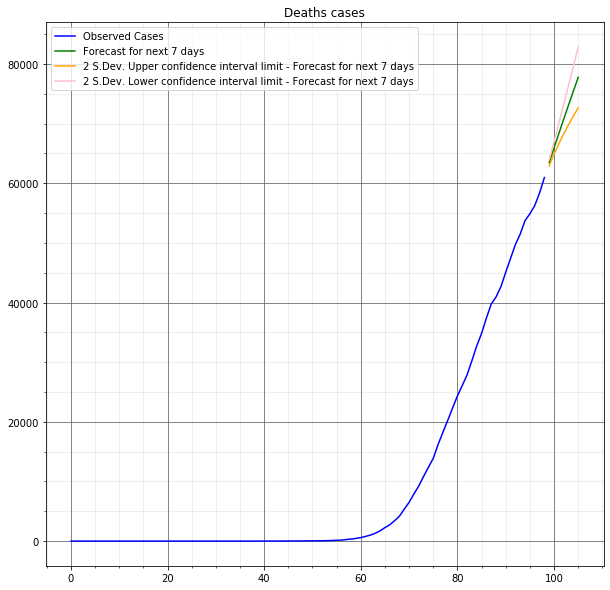

In [88]:
plot_arima(model_us_dea_arima,data_us,'Deaths',1,True)

### Belgium

/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/as

RMSE =  944.8993807954315
Average Percentage error (in %) =  1.7677506426012668


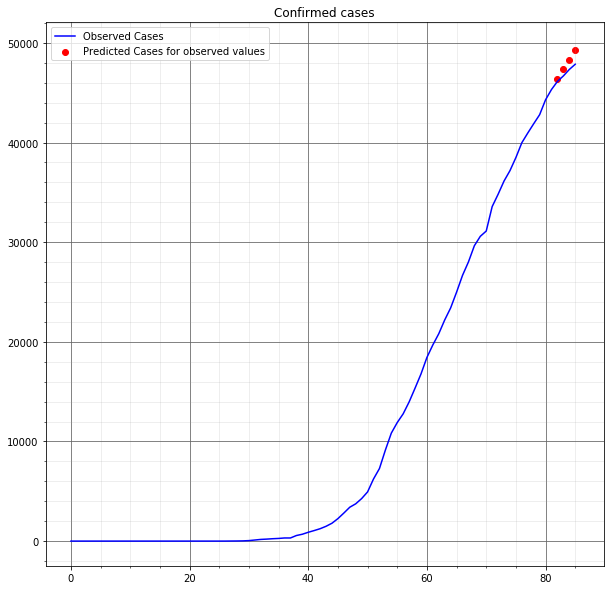

In [89]:
model_cnf = give_full_arima('Confirmed',data_bel,5,1,3)
plot_arima(model_cnf,data_bel,'Confirmed',0.96,False)

/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/as

RMSE =  29.817057001620935
Average Percentage error (in %) =  0.1961177272121707


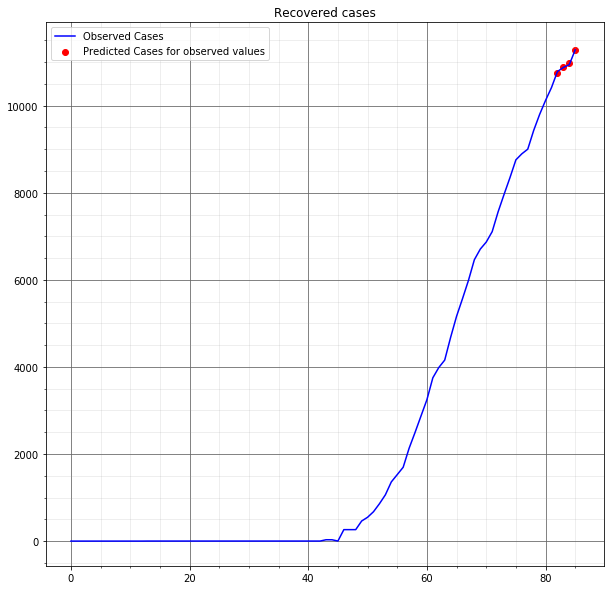

In [90]:
model_rec = give_full_arima('Recovered',data_bel,5,2,2)
plot_arima(model_rec,data_bel,'Recovered',0.96,False)

RMSE =  167.28050640935277
Average Percentage error (in %) =  1.985532586946027


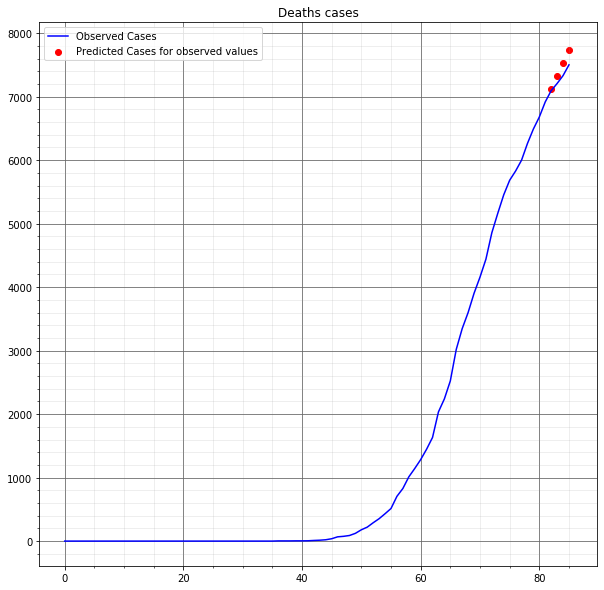

In [91]:
model_dea = give_full_arima('Deaths',data_bel,4,1,3)
plot_arima(model_dea,data_bel,'Deaths',0.96,False)

In [92]:
do_shit_arima('belgium','Confirmed',data_bel,5,1,3)
do_shit_arima('belgium','Recovered',data_bel,4,2,2)
do_shit_arima('belgium','Deaths',data_bel,4,1,3)

/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [93]:
model_belgium_cnf_arima = load_pickle('model_arima_belgium_Confirmed.pkl')
model_belgium_rec_arima = load_pickle('model_arima_belgium_Recovered.pkl')
model_belgium_dea_arima = load_pickle('model_arima_belgium_Deaths.pkl')

In [94]:
predict("2020-04-30","2020-05-07","belgium",model_belgium_cnf_arima,model_belgium_rec_arima,model_belgium_dea_arima,data_bel,'./test_op/',True)

,Date,Confirmed,Confirmed (95%) confidence interval,Recovered,Recovered CI,Deaths,Deaths CI
0,2020-04-30,48584,"[48048, 49120]",11627,"[11483, 11771]",7635,"[7542, 7727]"
1,2020-05-01,49318,"[48418, 50219]",11947,"[11700, 12193]",7780,"[7608, 7953]"
2,2020-05-02,49916,"[48665, 51168]",12335,"[12024, 12646]",7936,"[7685, 8187]"
3,2020-05-03,50469,"[48849, 52089]",12614,"[12216, 13013]",8069,"[7718, 8420]"
4,2020-05-04,50928,"[48928, 52928]",12757,"[12258, 13255]",8207,"[7752, 8662]"
5,2020-05-05,51449,"[48985, 53913]",12944,"[12351, 13537]",8354,"[7795, 8912]"
6,2020-05-06,52000,"[49018, 54982]",13218,"[12506, 13930]",8484,"[7811, 9158]"
7,2020-05-07,52613,"[49054, 56171]",13555,"[12697, 14413]",8617,"[7826, 9409]"


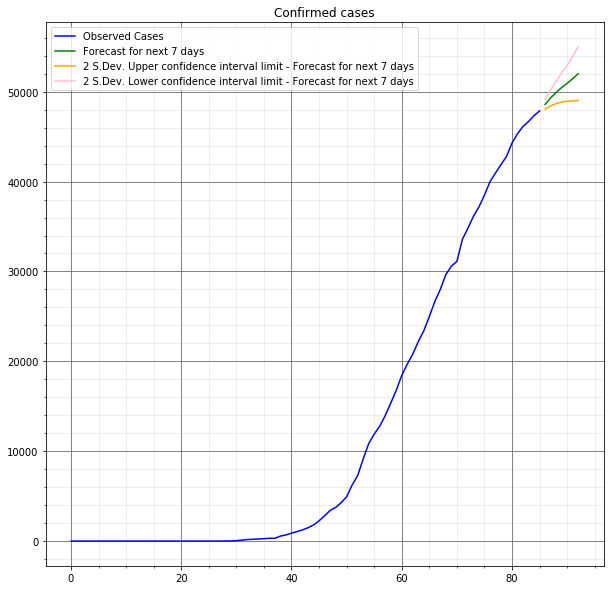

In [95]:
plot_arima(model_belgium_cnf_arima,data_bel,'Confirmed',1,True)

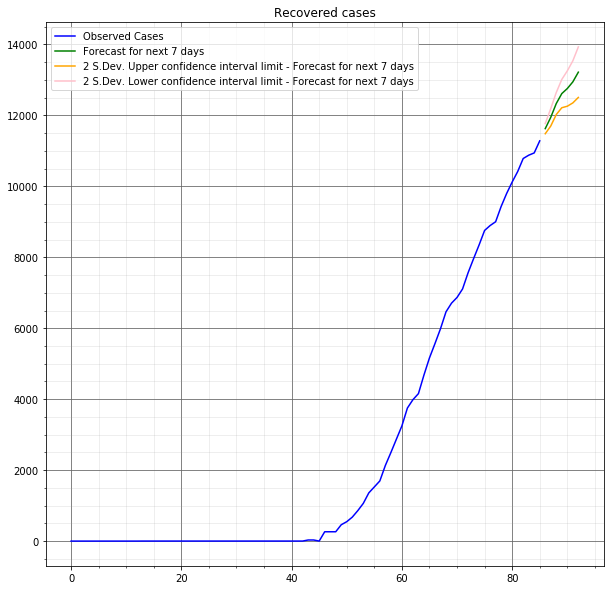

In [96]:
plot_arima(model_belgium_rec_arima,data_bel,'Recovered',1,True)

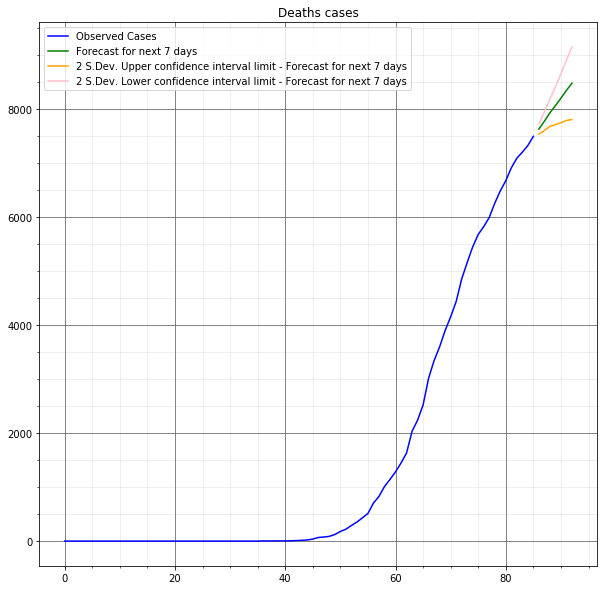

In [97]:
plot_arima(model_belgium_dea_arima,data_bel,'Deaths',1,True)

### Italy

RMSE =  1167.1808470392655
Average Percentage error (in %) =  0.5578983100654885


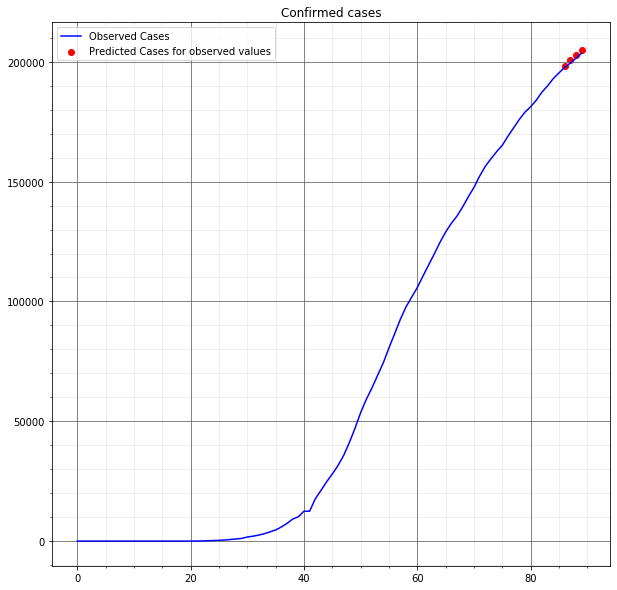

In [98]:
model_cnf = give_full_arima('Confirmed',data_italy,5,1,4)
plot_arima(model_cnf,data_italy,'Confirmed',0.96,False)

RMSE =  1701.857348164715
Average Percentage error (in %) =  2.3881905844293736


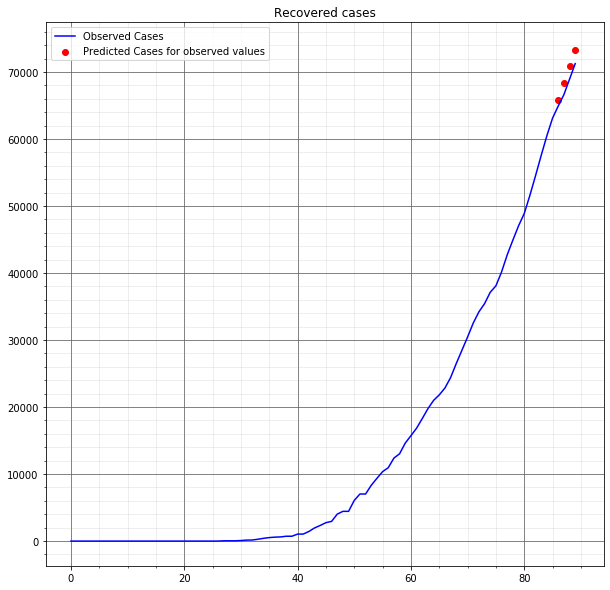

In [99]:
model_rec = give_full_arima('Recovered',data_italy,2,1,0)
plot_arima(model_rec,data_italy,'Recovered',0.96,False)

/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


RMSE =  189.50195750092865
Average Percentage error (in %) =  0.6727003818818704


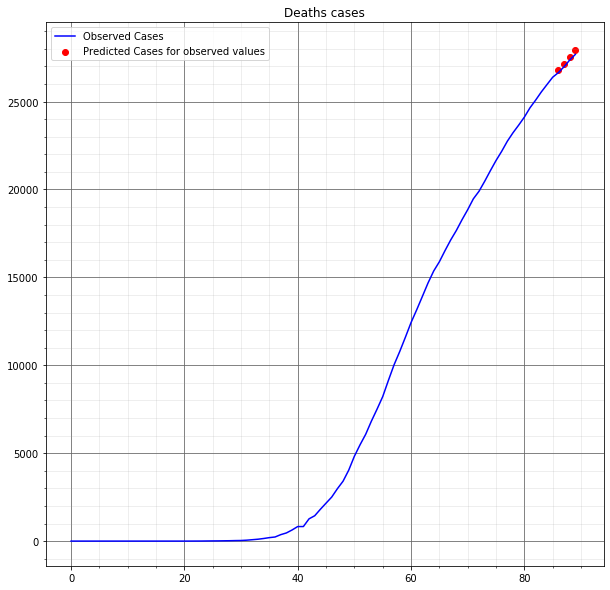

In [100]:
model_dea = give_full_arima('Deaths',data_italy,4,1,3)
plot_arima(model_dea,data_italy,'Deaths',0.96,False)

In [101]:
do_shit_arima('italy','Confirmed',data_italy,5,1,4)
do_shit_arima('italy','Recovered',data_italy,2,1,0)
do_shit_arima('italy','Deaths',data_italy,4,1,3)

/home/ashish-j/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [102]:
model_italy_cnf_arima = load_pickle('model_arima_italy_Confirmed.pkl')
model_italy_rec_arima = load_pickle('model_arima_italy_Recovered.pkl')
model_italy_dea_arima = load_pickle('model_arima_italy_Deaths.pkl')
predict("2020-04-30","2020-05-07","italy",model_italy_cnf_arima,model_italy_rec_arima,model_italy_dea_arima,data_italy,'./test_op/',True)

,Date,Confirmed,Confirmed (95%) confidence interval,Recovered,Recovered CI,Deaths,Deaths CI
0,2020-04-30,205258,"[204221, 206295]",73475,"[72701, 74249]",28055,"[27916, 28193]"
1,2020-05-01,206931,"[205345, 208518]",75644,"[74179, 77109]",28456,"[28218, 28695]"
2,2020-05-02,208569,"[206257, 210880]",77751,"[75442, 80060]",28815,"[28427, 29204]"
3,2020-05-03,210322,"[207262, 213382]",79801,"[76566, 83037]",29157,"[28574, 29740]"
4,2020-05-04,212105,"[208079, 216132]",81798,"[77559, 86037]",29522,"[28740, 30305]"
5,2020-05-05,213845,"[208595, 219096]",83743,"[78442, 89044]",29892,"[28906, 30877]"
6,2020-05-06,215446,"[208685, 222207]",85639,"[79227, 92051]",30243,"[29034, 31451]"
7,2020-05-07,216910,"[208442, 225377]",87489,"[79924, 95053]",30589,"[29139, 32039]"


### Forecasting : Italy

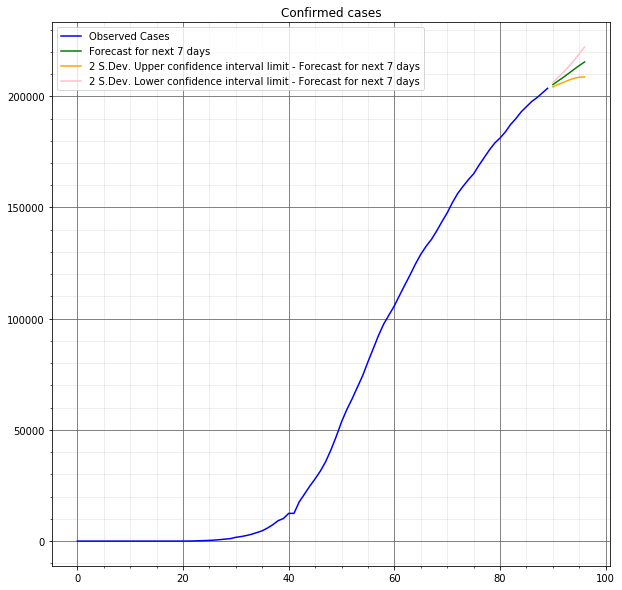

In [103]:
plot_arima(model_italy_cnf_arima,data_italy,'Confirmed',1,True)

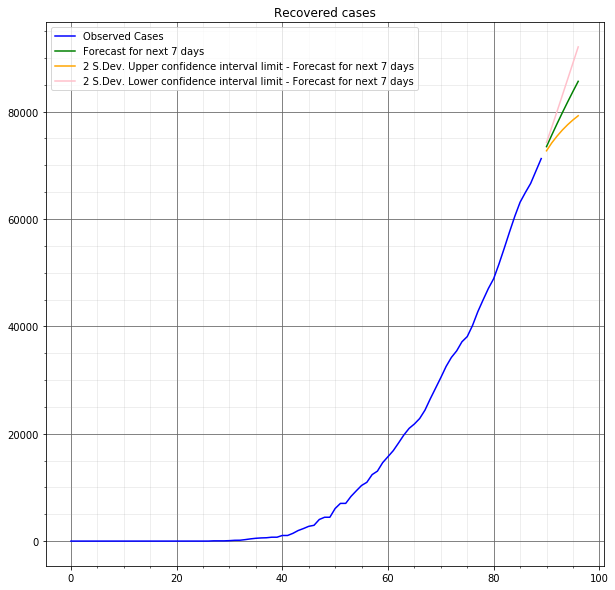

In [104]:
plot_arima(model_italy_rec_arima,data_italy,'Recovered',1,True)

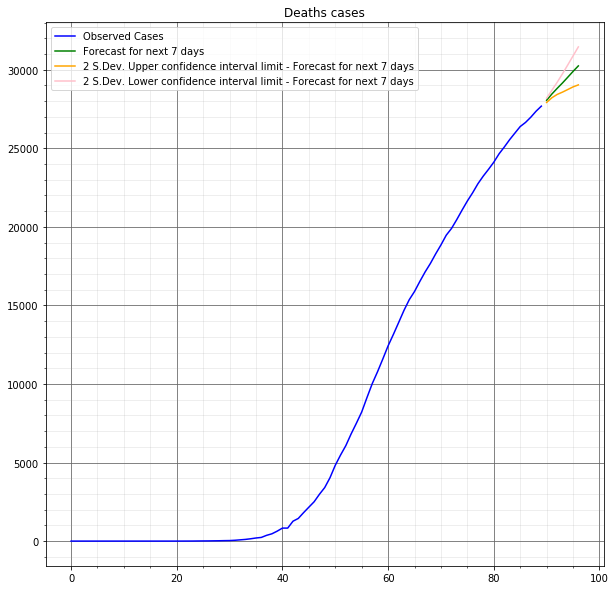

In [105]:
plot_arima(model_italy_dea_arima,data_italy,'Deaths',1,True)